# Load dataset & quick sanity check


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


DATA_PATH = "dataset/heart.csv"

df = pd.read_csv(DATA_PATH)

display(df.head())
print("Shape: ", df.shape)

print("\nDTypes: ")
display(df.dtypes)

print("\nMissing Values per column: ")
display(df.isna().sum())

print("\nTarget distribution (counts): ")
print(df["HeartDisease"].value_counts(dropna=False))

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Shape:  (918, 12)

DTypes: 


Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


Missing Values per column: 


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Target distribution (counts): 
HeartDisease
1    508
0    410
Name: count, dtype: int64


# EDA

In [2]:
# --- Cell 2: Exploratory Data Analysis (EDA) with simple plots ---

numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
display(numeric_columns)


['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease']

In [3]:
numeric_columns.remove('HeartDisease')
numeric_columns.remove('FastingBS')

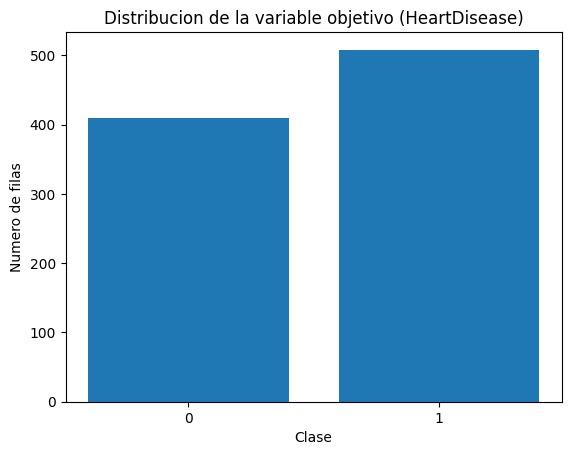

In [4]:
counts = df['HeartDisease'].value_counts(dropna=False).sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribucion de la variable objetivo (HeartDisease)")
plt.xlabel("Clase")
plt.ylabel("Numero de filas")
plt.show()

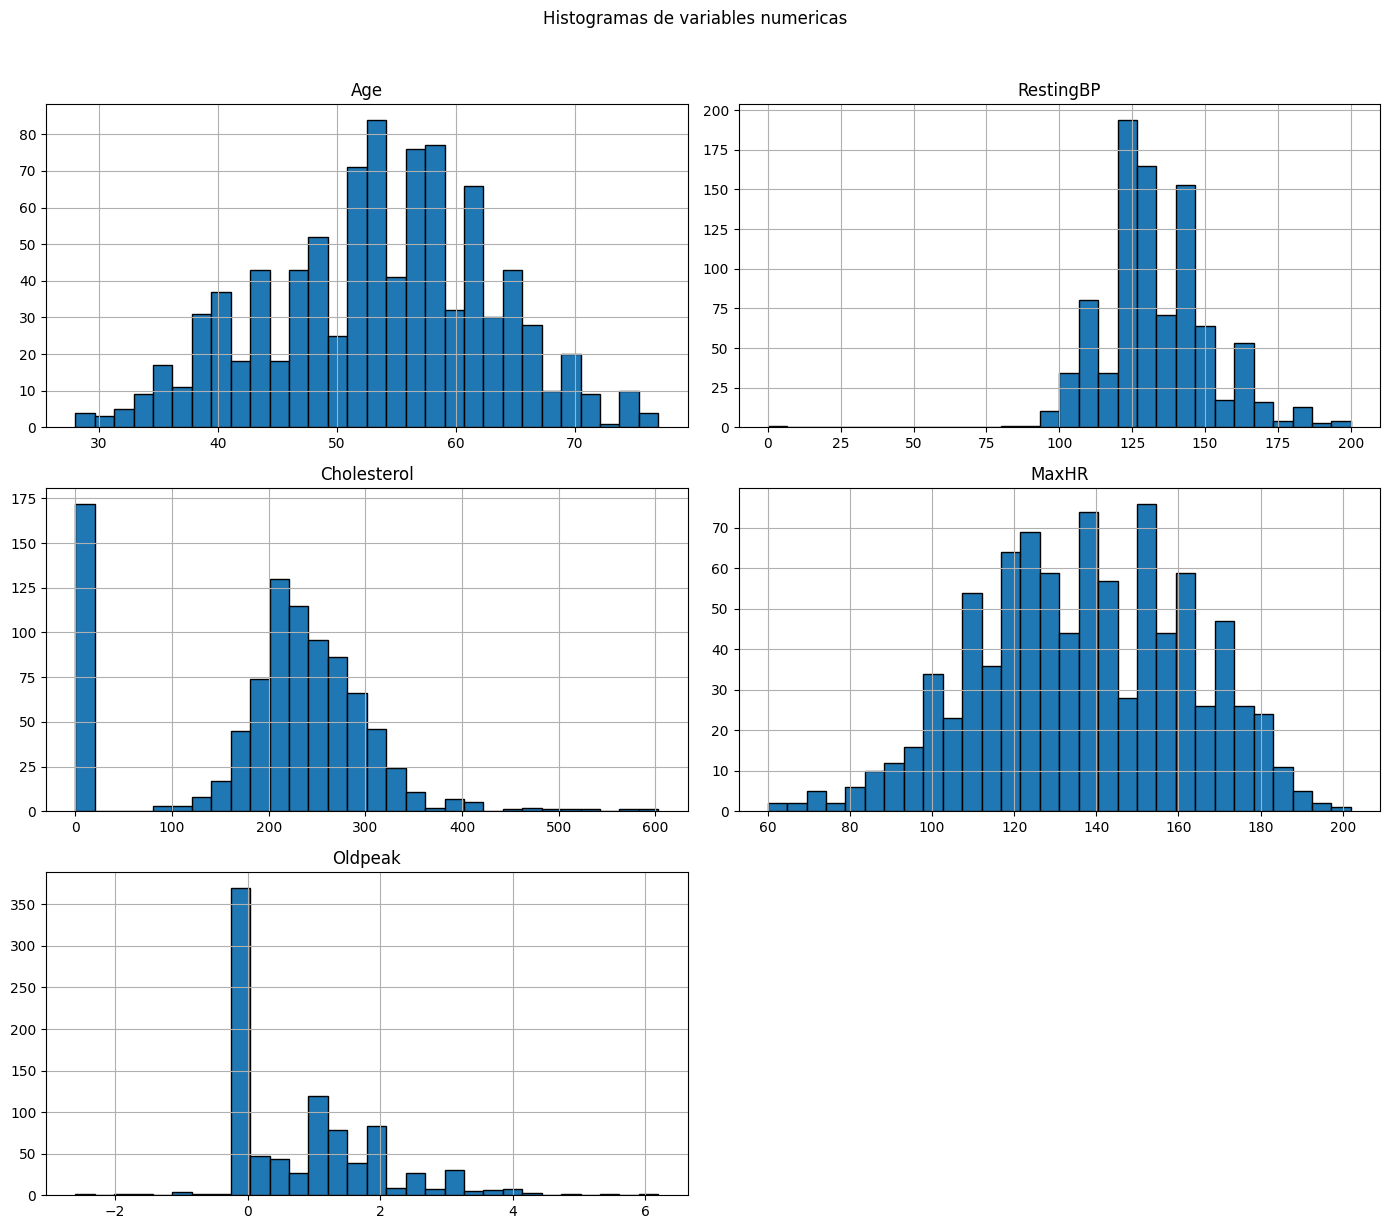

In [5]:
ax = df[numeric_columns].hist(bins=30, edgecolor="black", figsize=(14, 12))
plt.suptitle("Histogramas de variables numericas", y=1.02)
plt.tight_layout()
plt.show()

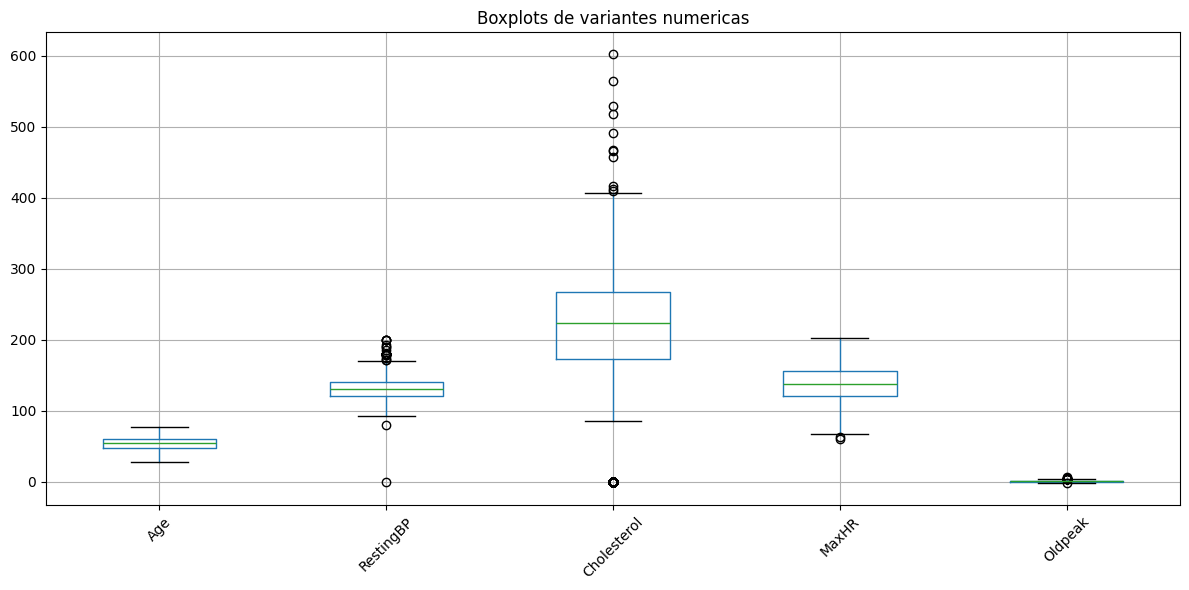

In [6]:
plt.figure(figsize=(12, 6))
df[numeric_columns].boxplot(rot=45)
plt.title("Boxplots de variantes numericas")
plt.tight_layout()
plt.show()

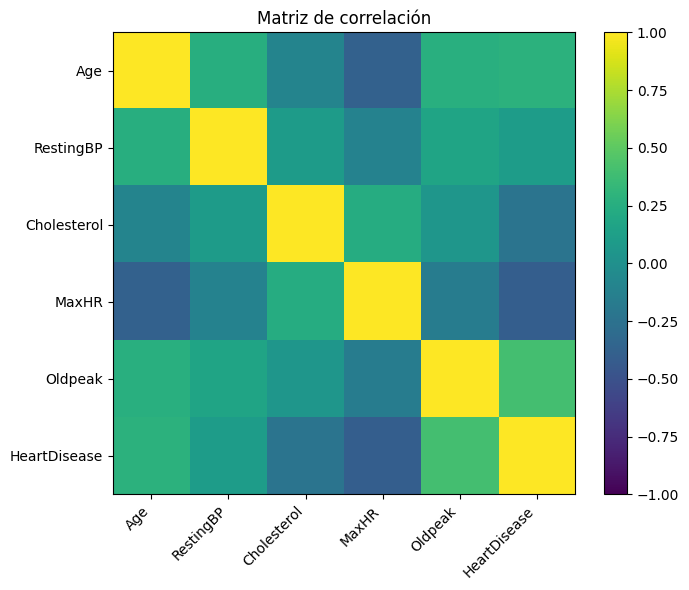

In [7]:
cols_for_corr = numeric_columns + (["HeartDisease"] if "HeartDisease" in df.columns else [])
corr = df[cols_for_corr].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(cols_for_corr)), labels=cols_for_corr, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(cols_for_corr)), labels=cols_for_corr)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# Train/Val/Test split + preprocessing

In [8]:
from sklearn.model_selection import train_test_split


TARGET = 'HeartDisease'

feature_columns = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    stratify=df[TARGET],
    random_state=42
)

df_train, df_val = train_test_split(
    df_temp,
    test_size=0.1765,
    stratify=df_temp[TARGET],
    random_state=42
)

def describe_split(name, d):
    n = len(d)
    counts = d[TARGET].value_counts(normalize=True).sort_index()
    print(f"{name}: {n} filas")
    if counts is not None:
        print(f"  proporción clase 0/1: {counts.to_dict()}")

describe_split("train", df_train)
describe_split("val", df_val)
describe_split("test", df_test)

train: 642 filas
  proporción clase 0/1: {0: 0.4454828660436137, 1: 0.5545171339563862}
val: 138 filas
  proporción clase 0/1: {0: 0.4492753623188406, 1: 0.5507246376811594}
test: 138 filas
  proporción clase 0/1: {0: 0.4492753623188406, 1: 0.5507246376811594}


In [9]:
# --- Celda: Preprocesamiento mínimo (después del split) ---
# - Estandariza numéricas
# - One-hot SOLO en categóricas necesarias
# - Cholesterol==0 -> NaN y se imputa por mediana

TARGET = "HeartDisease"

# Categóricas que requieren one-hot (si existen)
cat_cols = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]

# Numéricas = todo lo numérico excepto el target
num_cols = [c for c in df_train.select_dtypes(include=[np.number]).columns
            if c != TARGET]

# Cholesterol==0 -> NaN (si existe)
for part in (df_train, df_val, df_test):
    if "Cholesterol" in part.columns:
        part.loc[part["Cholesterol"] == 0, "Cholesterol"] = np.nan

# Parámetros SOLO con TRAIN
num_medians = df_train[num_cols].median()
num_means   = df_train[num_cols].mean()
num_stds    = df_train[num_cols].std().replace(0, 1.0)

# One-hot: fijamos columnas a partir de TRAIN
Xcat_train = pd.get_dummies(df_train[cat_cols].fillna("NA"))
cat_fixed_cols = Xcat_train.columns

def prep(d):
    y = d[TARGET].to_numpy(np.int64)

    # Numéricas -> imputación mediana + z-score
    Xnum = d[num_cols].copy().fillna(num_medians)
    Xnum = (Xnum - num_means) / num_stds

    # Categóricas -> one-hot con columnas del TRAIN
    Xcat = pd.get_dummies(d[cat_cols].fillna("NA"))
    Xcat = Xcat.reindex(columns=cat_fixed_cols, fill_value=0)

    X = pd.concat([Xnum, Xcat], axis=1).to_numpy(dtype=np.float32)
    return X, y

X_train, y_train = prep(df_train)
X_val,   y_val   = prep(df_val)
X_test,  y_test  = prep(df_test)


# DATASET AND DATALOADER

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [11]:
# Tensor

X_train_t = torch.from_numpy(X_train)
Y_train_t = torch.from_numpy(y_train).unsqueeze(1)

X_test_t = torch.from_numpy(X_test)
Y_test_t = torch.from_numpy(y_test).unsqueeze(1)

X_val_t = torch.from_numpy(X_val)
Y_val_t = torch.from_numpy(y_val).unsqueeze(1)

# Datasets and Datalaoders
BATCH_SIZE = 64

train_ds = TensorDataset(X_train_t, Y_train_t)
test_ds = TensorDataset(X_test_t, Y_test_t)
val_ds = TensorDataset(X_val_t, Y_val_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


xb, yb = next(iter(train_loader))
print("Batch shapes -> X:", tuple(xb.shape), "| y:", tuple(yb.shape))
print("dtypes -> ", xb.dtype, yb.dtype)


Batch shapes -> X: (64, 20) | y: (64, 1)
dtypes ->  torch.float32 torch.int64


# Training

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

torch.manual_seed(42)

input_dim = X_train.shape[1]
print("Input dim: ", input_dim)


class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 1)
        self.drop = nn.Dropout(p=0.325)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        logits = self.out(x).squeeze(1)
        return logits
    
model = MLP(input_dim).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


def evaluate(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    val_losses = []
    with torch.no_grad():
        for xb, yb, in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb) 
            loss = loss_fn(logits, yb.float().view_as(logits))
            val_losses.append(loss.item())
            all_logits.append(logits.cpu())
            all_targets.append(yb.cpu())
    logits = torch.cat(all_logits, dim=0).numpy().ravel()
    y_true = torch.cat(all_targets, dim=0).numpy().ravel()


    probs = 1 / (1 + np.exp(-logits))
    y_pred = (probs >= 0.5).astype(np.int32)


    acc = accuracy_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, probs)
    f1 = f1_score(y_true, y_pred)

    return np.mean(val_losses), acc, auroc, f1

EPOCHS = 250

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n_batches = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb.float().view_as(logits))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)
    val_loss, val_acc, val_auroc, val_f1 = evaluate(model, val_loader)

    print(f"Epoch {epoch:02d} | "
          f"train_loss: {train_loss:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f} | "
          f"val_auroc: {val_auroc:.4f} | "
          f"val_f1: {val_f1:.4f}")


Input dim:  20
Epoch 01 | train_loss: 0.6508 | val_loss: 0.6343 | val_acc: 0.8116 | val_auroc: 0.8990 | val_f1: 0.8375
Epoch 02 | train_loss: 0.5944 | val_loss: 0.5872 | val_acc: 0.8043 | val_auroc: 0.8941 | val_f1: 0.8323
Epoch 03 | train_loss: 0.5727 | val_loss: 0.5384 | val_acc: 0.8043 | val_auroc: 0.8956 | val_f1: 0.8323
Epoch 04 | train_loss: 0.4625 | val_loss: 0.5016 | val_acc: 0.8551 | val_auroc: 0.8956 | val_f1: 0.8684
Epoch 05 | train_loss: 0.4260 | val_loss: 0.4796 | val_acc: 0.8406 | val_auroc: 0.8962 | val_f1: 0.8533
Epoch 06 | train_loss: 0.4310 | val_loss: 0.4761 | val_acc: 0.8478 | val_auroc: 0.8977 | val_f1: 0.8609
Epoch 07 | train_loss: 0.4259 | val_loss: 0.4675 | val_acc: 0.8406 | val_auroc: 0.9026 | val_f1: 0.8571
Epoch 08 | train_loss: 0.4426 | val_loss: 0.4567 | val_acc: 0.8333 | val_auroc: 0.9066 | val_f1: 0.8535
Epoch 09 | train_loss: 0.4541 | val_loss: 0.4507 | val_acc: 0.8478 | val_auroc: 0.9079 | val_f1: 0.8609
Epoch 10 | train_loss: 0.3494 | val_loss: 0.4539 

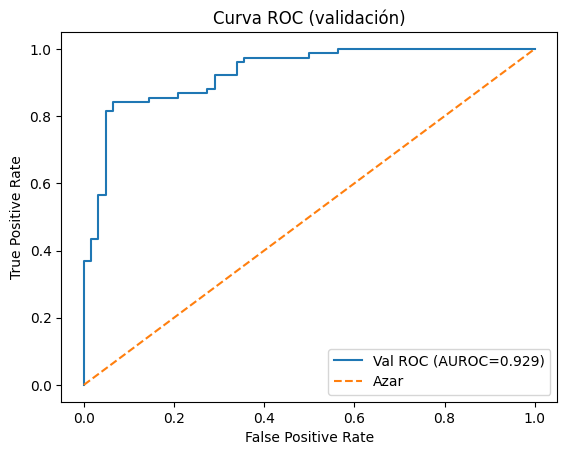

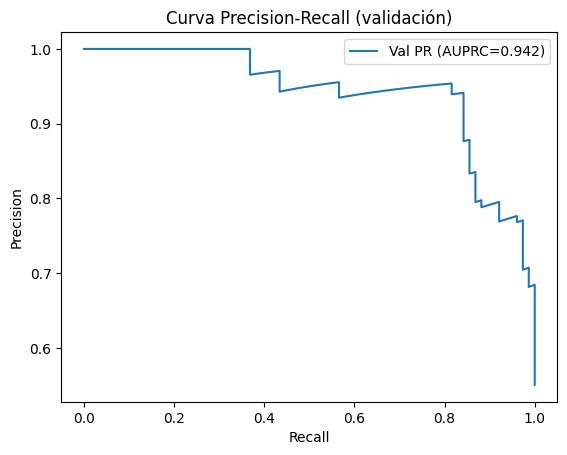

Best threshold on validation by F1: 0.7757  (F1=0.8889)

Test @ thr=0.5: {'thr': 0.5, 'acc': 0.8695652173913043, 'f1': 0.88, 'precision': 0.8918918918918919, 'recall': 0.868421052631579, 'auroc': 0.9314516129032258, 'cm': [[54, 8], [10, 66]]}
Confusion matrix @0.5  [[TN, FP],[FN, TP]]:
 [[54  8]
 [10 66]]

Test @ thr=best: {'thr': np.float32(0.7756911), 'acc': 0.855072463768116, 'f1': 0.8611111111111112, 'precision': 0.9117647058823529, 'recall': 0.8157894736842105, 'auroc': 0.9314516129032258, 'cm': [[56, 6], [14, 62]]}
Confusion matrix @best [[TN, FP],[FN, TP]]:
 [[56  6]
 [14 62]]


In [22]:
# --- Cell 6: Validation ROC/PR, threshold tuning, and Test evaluation ---

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score
)

model.eval()

def collect_logits_and_targets(model, loader, device):
    logits_list, targets_list = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            logits_list.append(logits.cpu().numpy().ravel())
            targets_list.append(yb.cpu().numpy().ravel())
    logits = np.concatenate(logits_list)
    y_true = np.concatenate(targets_list).astype(int)
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    return logits, probs, y_true

# Recoger predicciones/etiquetas de validación y test
val_logits, val_probs, y_val_true = collect_logits_and_targets(model, val_loader, device)
test_logits, test_probs, y_test_true = collect_logits_and_targets(model, test_loader, device)

# 1) Curva ROC (validación)
fpr, tpr, roc_thresholds = roc_curve(y_val_true, val_probs)
val_auroc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Val ROC (AUROC={val_auroc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (validación)")
plt.legend()
plt.show()

# 2) Curva Precision-Recall (validación)
precision, recall, pr_thresholds = precision_recall_curve(y_val_true, val_probs)
val_aupr = average_precision_score(y_val_true, val_probs)

plt.figure()
plt.plot(recall, precision, label=f"Val PR (AUPRC={val_aupr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (validación)")
plt.legend()
plt.show()

# 3) Selección de umbral en validación: maximizar F1
#    (nota: len(pr_thresholds) = len(precision) - 1)
f1s, ths = [], []
for th in pr_thresholds:
    y_pred = (val_probs >= th).astype(int)
    f1s.append(f1_score(y_val_true, y_pred))
    ths.append(th)

best_idx = int(np.argmax(f1s)) if len(f1s) > 0 else 0
best_thr = ths[best_idx] if len(ths) > 0 else 0.5
print(f"Best threshold on validation by F1: {best_thr:.4f}  (F1={f1s[best_idx]:.4f})")

# 4) Métricas en TEST @ umbral 0.5 y @ mejor umbral
def report_metrics(y_true, probs, thr):
    y_pred = (probs >= thr).astype(int)
    return {
        "thr": thr,
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "auroc": roc_auc_score(y_true, probs),
        "cm": confusion_matrix(y_true, y_pred)
    }

test_report_05 = report_metrics(y_test_true, test_probs, 0.5)
test_report_best = report_metrics(y_test_true, test_probs, best_thr)

print("\nTest @ thr=0.5:", {k: (v if k!='cm' else v.tolist()) for k,v in test_report_05.items()})
print("Confusion matrix @0.5  [[TN, FP],[FN, TP]]:\n", test_report_05["cm"])

print("\nTest @ thr=best:", {k: (v if k!='cm' else v.tolist()) for k,v in test_report_best.items()})
print("Confusion matrix @best [[TN, FP],[FN, TP]]:\n", test_report_best["cm"])
